In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np

c:\msc_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
G = nx.Graph()

In [4]:
# read the data file and convert it to a dictionary
# dictionary = {testcase ID (int): {"testcase": testcase name, "exec_line": list of executed lines}}
D = dict()
key_count = 0
previous_test_case = ''
with open('dataset/assertj-core1_2013.txt') as f:
    for line in f:
        l_line = line.rstrip().split("\t")
        if previous_test_case != l_line[1]:
            previous_test_case = l_line[1]
            key_count += 1
        if key_count in D:
            D[key_count]["exec_line"].append(l_line[2]+l_line[3])
        else:
            D[key_count] = {"testcase": l_line[1], "exec_line":[l_line[2]+l_line[3]]}



dict_items([((1, 2), 26), ((1, 3), 62), ((1, 4), 62), ((1, 5), 12), ((1, 6), 16), ((1, 7), 12), ((1, 9), 16), ((1, 10), 19), ((1, 11), 16), ((1, 12), 15), ((1, 13), 12), ((1, 14), 17), ((1, 15), 12), ((1, 16), 16), ((1, 17), 15), ((1, 18), 14), ((1, 19), 27), ((1, 20), 26), ((1, 21), 12), ((1, 22), 10), ((1, 23), 8), ((2, 3), 25), ((2, 4), 25), ((2, 5), 26), ((2, 6), 25), ((2, 7), 25), ((2, 9), 26), ((2, 10), 10), ((2, 11), 13), ((2, 12), 12), ((2, 13), 26), ((2, 14), 13), ((2, 15), 12), ((2, 16), 12), ((2, 17), 12), ((2, 18), 13), ((2, 19), 10), ((2, 20), 10), ((2, 21), 12), ((2, 22), 10), ((2, 23), 5), ((3, 4), 62), ((3, 5), 12), ((3, 6), 15), ((3, 7), 12), ((3, 9), 16), ((3, 10), 19), ((3, 11), 15), ((3, 12), 15), ((3, 13), 12), ((3, 14), 16), ((3, 15), 12), ((3, 16), 16), ((3, 17), 15), ((3, 18), 12), ((3, 19), 26), ((3, 20), 26), ((3, 21), 12), ((3, 22), 10), ((3, 23), 8), ((4, 5), 12), ((4, 6), 15), ((4, 7), 12), ((4, 9), 16), ((4, 10), 19), ((4, 11), 15), ((4, 12), 15), ((4, 13)

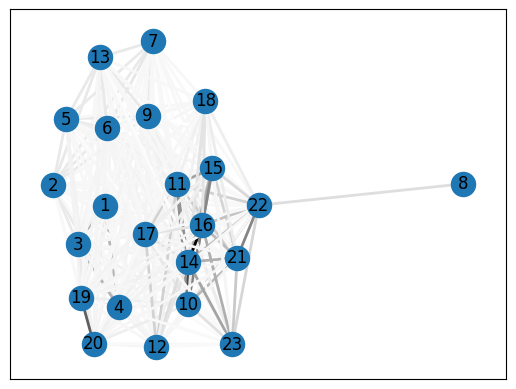

In [5]:
# Create a graph
# networkx's document is refered.
# https://networkx.org/documentation/stable/tutorial.html

# add nodes
for i in D:
    # print(i)
    # print(D[i]["testcase"])
    G.add_node(i)

# add weighted edge: the number of common executed lines is the weight of edge.
for i in range(1, len(D)+1):
    for j in range(i+1, len(D)+1):
        weight = len(set(D[i]["exec_line"]) & set(D[j]["exec_line"]))
        if weight != 0:
            G.add_weighted_edges_from([(i,j,weight)])

edges = G.edges(data=True)
weight_set = ()

# draw the graph with colored edges according to the weight.
# the code "edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())"
# refers to : https://www.tutorialspoint.com/colouring-the-edges-by-weight-in-networkx-matplotlib
print(nx.get_edge_attributes(G, 'weight').items())
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw_networkx(G,width=2, edge_color=weights, edge_cmap=plt.cm.Greys)
               
               
    

Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 51.89it/s]


[[1.9315674  3.1315894 ]
 [2.554785   1.3188628 ]
 [3.885467   0.10772764]
 [2.8332756  3.0111992 ]
 [4.5312667  1.2085723 ]
 [5.0455213  2.7104445 ]
 [3.847439   1.0911578 ]
 [3.4140081  0.62289333]
 [2.3958626  3.8644621 ]
 [1.7780231  1.4238482 ]
 [2.9060426  2.1269233 ]
 [1.5264548  2.0744877 ]
 [3.5007048  1.8067262 ]
 [3.9351296  3.7359352 ]
 [3.3201742  3.6454124 ]
 [2.8995712  3.871154  ]
 [3.9913955  3.5367212 ]
 [2.9396577  2.3070698 ]
 [4.298873   2.271801  ]
 [3.099466   0.7488354 ]
 [2.389218   0.5638367 ]
 [3.488967   1.9528251 ]
 [5.01321    1.9574107 ]]


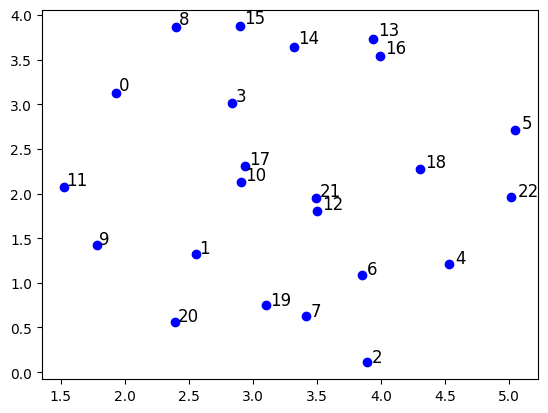

In [7]:
# Create Embedding
# https://github.com/eliorc/node2vec
# for destination in G.neighbors(1):
#     print(destination)
#     if G[1][destination].get("weight"):
#         weight = G[1][destination].get("weight", 1)
#         print("weight between 1 and destination is:", weight)
        
node2vec = Node2Vec(G, dimensions=10)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# print(len(model.wv))
# for i in range(0,23):
#     print(model.wv[i])
embeddings = np.array([model.wv[x-1] for x in G.nodes])

# reduce the dimension using t-SNE
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)
print(embeddings_2d)
# visualise the embeddings
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# plt.show()

for i in range(len(embeddings_2d)):
    x = embeddings_2d[i][0]
    y = embeddings_2d[i][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

plt.show()

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py